### TODO

- ~~Change Image constructor to accept the shape of another image~~
- ~~Add the possibility to create an Image from a Tensor (To access the image corresponding to a trained Tensor)~~
- ~~Normalize the images~~ 
- Make sure the training remains in valid values for pixels
- Log the evolution of train loss in TensorFlow
- Create a custom loss function to compute MSE on features dicts, with potentially many features in one dict
- Create a function for Gram matrices computation
- Create the style loss function from Gram matrices
- Optimize the hyperparameters

--> Create the best Style Transfer AI and let it dominate the world

In [1]:
import torch
import lightning as L
import numpy as np
import cv2 as cv
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm.auto import tqdm

from image import Image
from hooked_vgg import Hooked_VGG

In [ ]:
img_base = Image(Path('./test_images/wolf_forest.jpg'))
img_train = Image(white_noise_shape=img_base.shape)

model = Hooked_VGG(0)

base_feat = model.get_features(img_base.to_tensor())[0]

MAX_EPOCH = 1000

train_tensor = torch.nn.Parameter(img_train.to_tensor().clone().detach().requires_grad_(True))

optim = torch.optim.Adam([train_tensor], lr=0.01)

loss_fn = torch.nn.MSELoss()

for _ in tqdm(range(MAX_EPOCH)):
    optim.zero_grad()

    train_feat = model.get_features(train_tensor)[0]

    loss = loss_fn(train_feat, base_feat)
    loss.backward()

    optim.step()

reduce


  0%|          | 0/1000 [00:00<?, ?it/s]

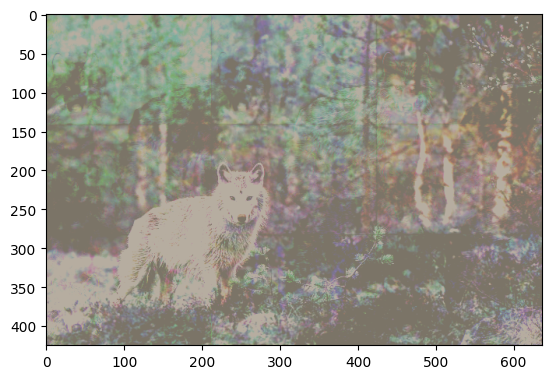

In [31]:
trained_img = Image(train_tensor)
trained_img.show()

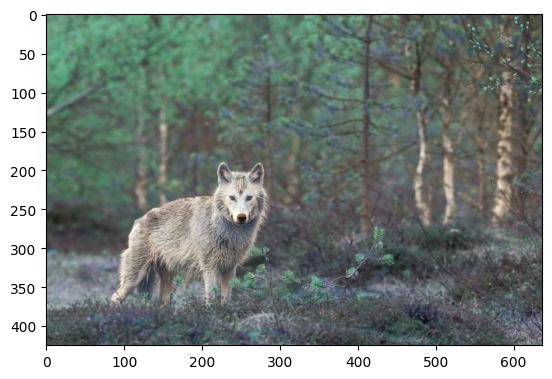

In [ ]:
img_base.show()

In [10]:
t = torch.Tensor([[[1,2,3]]])
len(t)

1

In [21]:
model.vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo